1637


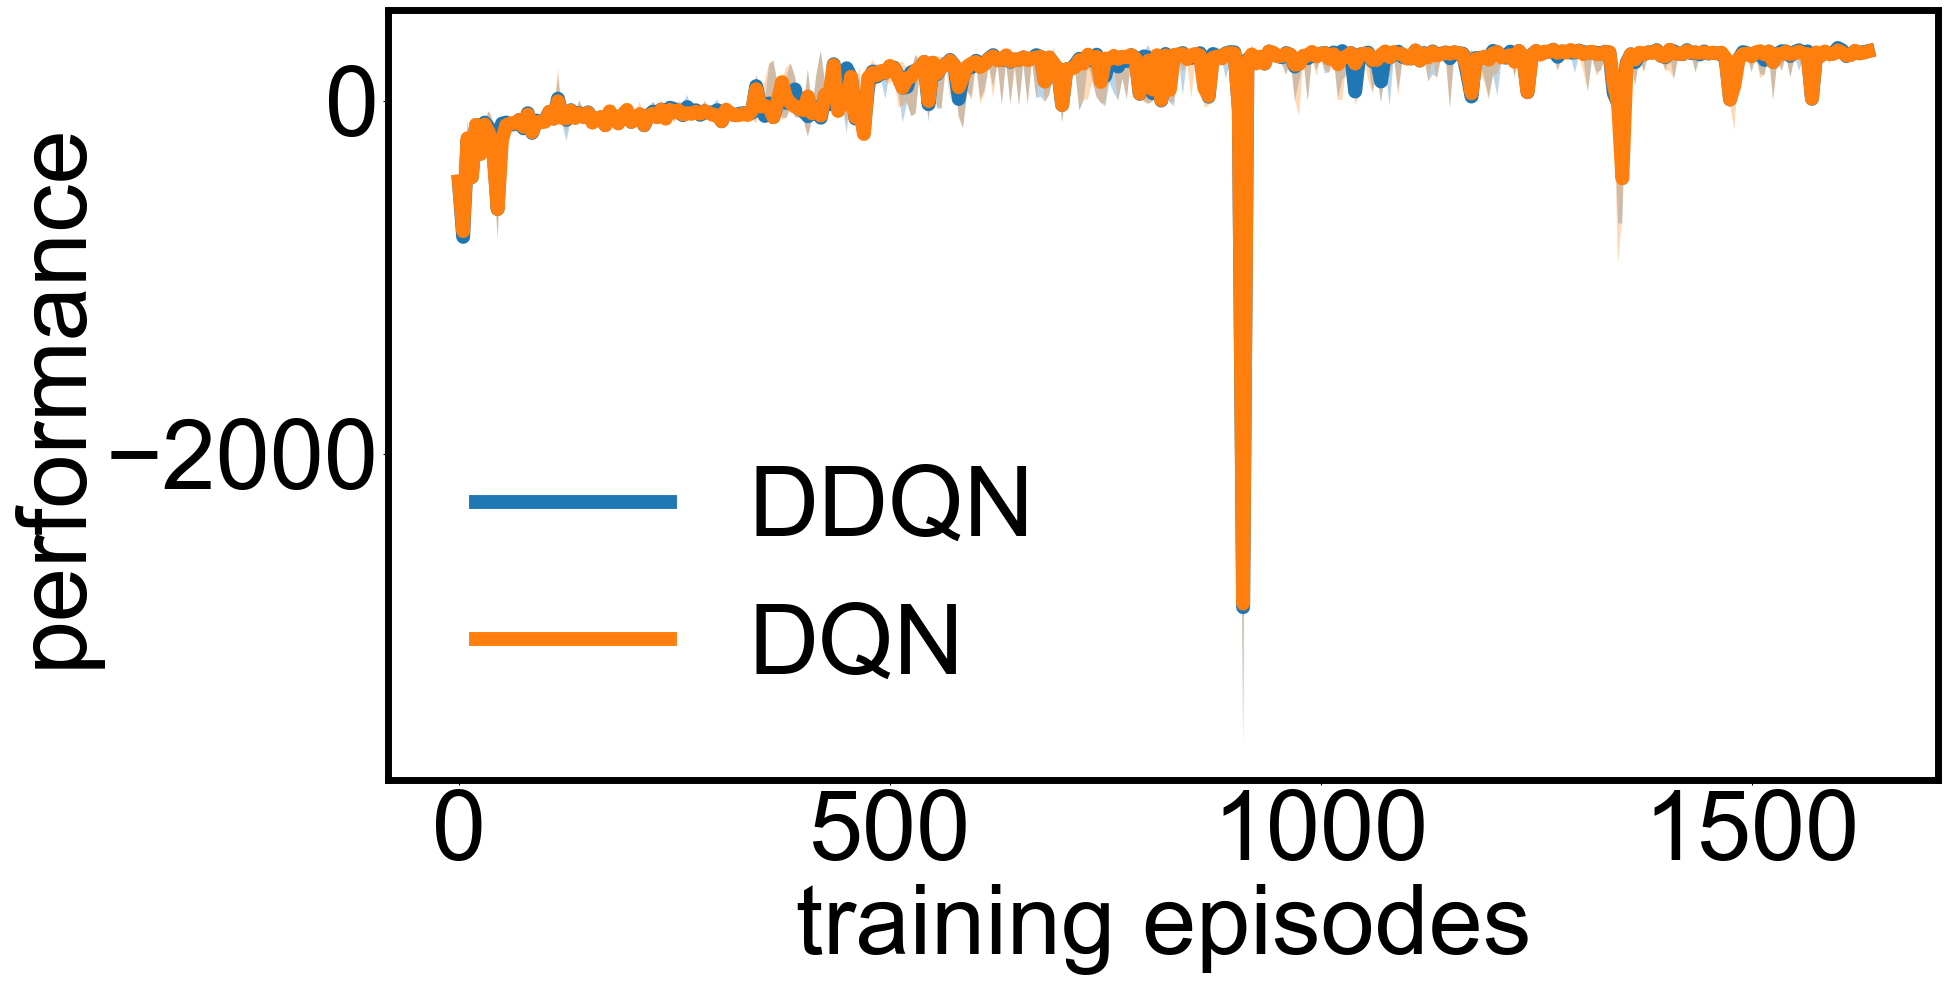

In [1]:
"""
In this script we show how to test and plot RL results.

"""
import sys

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from bbrl_algos.rliable_stats.tests import run_test

font = {"family": "arial", "size": 70}
matplotlib.rc("font", **font)
sys.path.append("../")


save = False  # save in ./plot.png if True

sac_perfs = np.loadtxt("bbrl_algos/rliable_stats/data_files/ddqn_LunarLander-v2.data").T

td3_perfs = np.loadtxt("bbrl_algos/rliable_stats/data_files/dqn_LunarLander-v2.data").T
nb_datapoints = sac_perfs.shape[1]
nb_steps = sac_perfs.shape[0]

print(nb_steps)
legend = ["DDQN", "DQN"]

# what do you want to plot ?
id_central = "median"  # 'mean'
id_error = 80  # (percentiles), also: 'std', 'sem'

# which test ?
# possible : ['t-test', "Welch t-test", 'Mann-Whitney', 'Ranked t-test', 'bootstrap', 'permutation']
test_id = "Welch t-test"  # recommended
confidence_level = 0.01

sample_size = 20
sample1 = sac_perfs[:, np.random.randint(0, nb_datapoints, sample_size)]
sample2 = td3_perfs[:, np.random.randint(0, nb_datapoints, sample_size)]

# downsample for visualization purpose
downsampling_fact = 5
steps = np.arange(0, nb_steps, downsampling_fact)
sample1 = sample1[steps, :]
sample2 = sample2[steps, :]

# test
sign_diff = np.zeros([len(steps)])
for i in range(len(steps)):
    sign_diff[i] = run_test(
        test_id, sample1[i, :], sample2[i, :], alpha=confidence_level
    )


def compute_central_tendency_and_error(id_central, id_error, sample):
    if id_central == "mean":
        central = np.nanmean(sample, axis=1)
    elif id_central == "median":
        central = np.nanmedian(sample, axis=1)
    else:
        raise NotImplementedError

    if isinstance(id_error, int):
        low = np.nanpercentile(sample, q=int((100 - id_error) / 2), axis=1)
        high = np.nanpercentile(sample, q=int(100 - (100 - id_error) / 2), axis=1)
    elif id_error == "std":
        low = central - np.nanstd(sample, axis=1)
        high = central + np.nanstd(sample, axis=1)
    elif id_error == "sem":
        low = central - np.nanstd(sample, axis=1) / np.sqrt(sample.shape[0])
        high = central + np.nanstd(sample, axis=1) / np.sqrt(sample.shape[0])
    else:
        raise NotImplementedError

    return central, low, high


central1, low1, high1 = compute_central_tendency_and_error(
    id_central, id_error, sample1
)
central2, low2, high2 = compute_central_tendency_and_error(
    id_central, id_error, sample2
)

# plot
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
lab1 = plt.xlabel("training episodes")
lab2 = plt.ylabel("performance")

plt.plot(steps, central1, linewidth=10)
plt.plot(steps, central2, linewidth=10)
plt.fill_between(steps, low1, high1, alpha=0.3)
plt.fill_between(steps, low2, high2, alpha=0.3)
leg = ax.legend(legend, frameon=False)

# plot significative difference as dots
idx = np.argwhere(sign_diff == 1)
y = max(np.nanmax(high1), np.nanmax(high2))
plt.scatter(steps[idx], y * 1.05 * np.ones([idx.size]), s=100, c="k", marker="o")


# style
for line in leg.get_lines():
    line.set_linewidth(10.0)
ax.spines["top"].set_linewidth(5)
ax.spines["right"].set_linewidth(5)
ax.spines["bottom"].set_linewidth(5)
ax.spines["left"].set_linewidth(5)

if save:
    plt.savefig(
        "./plot.png", bbox_extra_artists=(leg, lab1, lab2), bbox_inches="tight", dpi=100
    )

plt.show()

In [2]:
#
#  Copyright © Sorbonne University.
#
#  This source code is licensed under the MIT license found in the
#  LICENSE file in the root directory of this source tree.
#

import copy
import os
import numpy as np
from typing import Callable, List

import hydra
import optuna
from omegaconf import DictConfig

# %%
import torch
import torch.nn as nn

# %%
from bbrl.agents.gymnasium import record_video
from moviepy.editor import ipython_display as video_display
import gymnasium as gym
from gymnasium import Env
from gymnasium.wrappers import AutoResetWrapper

# %%
from bbrl import get_arguments, get_class
from bbrl.agents import TemporalAgent, Agents, PrintAgent
from bbrl.workspace import Workspace

from bbrl_algos.models.exploration_agents import EGreedyActionSelector
from bbrl_algos.models.critics import DiscreteQAgent
from bbrl_algos.models.loggers import Logger
from bbrl_algos.models.utils import save_best

from bbrl.visu.plot_critics import plot_discrete_q, plot_critic
from bbrl_algos.models.hyper_params import launch_optuna

from bbrl.utils.functional import gae
from bbrl.utils.chrono import Chrono

# HYDRA_FULL_ERROR = 1
import matplotlib
import matplotlib.pyplot as plt

from bbrl_gymnasium.envs.maze_mdp import MazeMDPEnv
from bbrl_algos.wrappers.env_wrappers import MazeMDPContinuousWrapper
from bbrl.agents.gymnasium import make_env, ParallelGymAgent
from functools import partial


matplotlib.use("Agg")


f:\Machine_Learning\Anaconda\envs\IAR\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Matplotlib backend: module://matplotlib_inline.backend_inline


In [3]:
def local_get_env_agents(cfg):
    eval_env_agent = ParallelGymAgent(
        partial(
            make_env,
            cfg.gym_env.env_name,
            autoreset=False,
        ),
        cfg.algorithm.nb_evals,
        include_last_state=True,
        seed=cfg.algorithm.seed.eval,
    )
    train_env_agent = ParallelGymAgent(
        partial(
            make_env,
            cfg.gym_env.env_name,
            autoreset=True,
        ),
        cfg.algorithm.n_envs,
        include_last_state=True,
        seed=cfg.algorithm.seed.train,
    )
    return train_env_agent, eval_env_agent


# %%
def compute_critic_loss(
    discount_factor, reward, must_bootstrap, action, q_values, q_target=None
):
    """Compute critic loss
    Args:
        discount_factor (float): The discount factor
        reward (torch.Tensor): a (2 × T × B) tensor containing the rewards
        must_bootstrap (torch.Tensor): a (2 × T × B) tensor containing 0 if the episode is completed at time $t$
        action (torch.LongTensor): a (2 × T) long tensor containing the chosen action
        q_values (torch.Tensor): a (2 × T × B × A) tensor containing Q values
        q_target (torch.Tensor, optional): a (2 × T × B × A) tensor containing target Q values

    Returns:
        torch.Scalar: The loss
    """
    
    best_action = q_values[1].argmax(dim=-1).detach()

    max_q = q_target[1].gather(-1, best_action.unsqueeze(-1)).squeeze().detach()

    target = reward[1] + discount_factor * max_q * must_bootstrap[1]

    act = action[0].unsqueeze(dim=-1)
    qvals = q_values[0].gather(dim=1, index=act).squeeze(dim=1)

    return nn.MSELoss()(qvals, target)


# %%
def create_dqn_agent(cfg_algo, train_env_agent, eval_env_agent):
    # obs_space = train_env_agent.get_observation_space()
    # obs_shape = obs_space.shape if len(obs_space.shape) > 0 else obs_space.n

    # act_space = train_env_agent.get_action_space()
    # act_shape = act_space.shape if len(act_space.shape) > 0 else act_space.n

    state_dim, action_dim = train_env_agent.get_obs_and_actions_sizes()
    print(cfg_algo.architecture.hidden_sizes)

    critic = DiscreteQAgent(
        state_dim=state_dim,
        hidden_layers=list(cfg_algo.architecture.hidden_sizes),
        action_dim=action_dim,
        seed=cfg_algo.seed.q,
    )
    target_critic = copy.deepcopy(critic)

    explorer = EGreedyActionSelector(
        name="action_selector",
        epsilon=cfg_algo.explorer.epsilon_start,
        epsilon_end=cfg_algo.explorer.epsilon_end,
        epsilon_decay=cfg_algo.explorer.decay,
        seed=cfg_algo.seed.explorer,
    )
    q_agent = TemporalAgent(critic)
    target_q_agent = TemporalAgent(critic)

    tr_agent = Agents(train_env_agent, critic, explorer)  # , PrintAgent())
    ev_agent = Agents(eval_env_agent, critic)

    # Get an agent that is executed on a complete workspace
    train_agent = TemporalAgent(tr_agent)
    eval_agent = TemporalAgent(ev_agent)
    

    return train_agent, eval_agent, q_agent, target_q_agent


# %%
# Configure the optimizer over the q agent
def setup_optimizer(optimizer_cfg, q_agent):
    optimizer_args = get_arguments(optimizer_cfg)
    parameters = q_agent.parameters()
    optimizer = get_class(optimizer_cfg)(parameters, **optimizer_args)
    return optimizer


# %%
def run_dqn(cfg, logger, trial=None):
    best_reward = float("-inf")
    best_agent = None

    if cfg.collect_stats:
        directory = "./dqn_data/"
        if not os.path.exists(directory):
            os.makedirs(directory)
        filename = directory + "dqn_" + cfg.gym_env.env_name + ".data"
        fo = open(filename, "wb")
        stats_data = []

    # 1) Create the environment agent
    train_env_agent, eval_env_agent = local_get_env_agents(cfg)
    print(train_env_agent.envs[0])
    print(eval_env_agent.envs[0])

    # 2) Create the DQN-like Agent
    train_agent, eval_agent, q_agent, target_q_agent = create_dqn_agent(
        cfg.algorithm, train_env_agent, eval_env_agent
    )

    # 3) Create the training workspace
    train_workspace = Workspace()  # Used for training

    # 5) Configure the optimizer
    optimizer = setup_optimizer(cfg.optimizer, q_agent)

    # 6) Define the steps counters
    nb_steps = 0
    tmp_steps_eval = 0

    while nb_steps < cfg.algorithm.n_steps:
        # Decay the explorer epsilon
        explorer = train_agent.agent.get_by_name("action_selector")
        assert len(explorer) == 1, "There should be only one explorer"
        explorer[0].decay()

        # Execute the agent in the workspace
        if nb_steps > 0:
            train_workspace.zero_grad()
            train_workspace.copy_n_last_steps(1)
            train_agent(
                train_workspace,
                t=1,
                n_steps=cfg.algorithm.n_steps_train - 1,
            )
        else:
            train_agent(
                train_workspace,
                t=0,
                n_steps=cfg.algorithm.n_steps_train,
            )

        transition_workspace: Workspace = train_workspace.get_transitions(
            filter_key="env/done"
        )

        # Only get the required number of steps
        steps_diff = cfg.algorithm.n_steps - nb_steps
        if transition_workspace.batch_size() > steps_diff:
            for key in transition_workspace.keys():
                transition_workspace.set_full(
                    key, transition_workspace[key][:, :steps_diff]
                )

        nb_steps += transition_workspace.batch_size()

        # The q agent needs to be executed on the rb_workspace workspace (gradients are removed in workspace).
        q_agent(transition_workspace, t=0, n_steps=2, choose_action=False)

        q_values, terminated, reward, action = transition_workspace[
            "critic/q_values",
            "env/terminated",
            "env/reward",
            "action",
        ]

        with torch.no_grad():
                    target_q_agent(transition_workspace, t=0, n_steps=2, stochastic=True)
        target_q_values = transition_workspace["critic/q_values"]

        # Determines whether values of the critic should be propagated
        # True if the task was not terminated.
        must_bootstrap = ~terminated

        critic_loss = compute_critic_loss(
            cfg.algorithm.discount_factor,
            reward,
            must_bootstrap,
            action,
            q_values,
            target_q_values
        )

        # Store the loss
        logger.add_log("critic_loss", critic_loss, nb_steps)

        optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(
            q_agent.parameters(), cfg.algorithm.max_grad_norm
        )

        optimizer.step()

        # Evaluate the agent
        if nb_steps - tmp_steps_eval > cfg.algorithm.eval_interval:
            tmp_steps_eval = nb_steps
            eval_workspace = Workspace()  # Used for evaluation
            eval_agent(
                eval_workspace,
                t=0,
                stop_variable="env/done",
                choose_action=True,
            )
            rewards = eval_workspace["env/cumulated_reward"][-1]
            logger.log_reward_losses(rewards, nb_steps)
            mean = rewards.mean()

            if mean > best_reward:
                best_reward = mean
                best_agent = copy.deepcopy(eval_agent)

            print(
                f"nb_steps: {nb_steps}, reward: {mean:.02f}, best: {best_reward:.02f}"
            )

            if trial is not None:
                trial.report(mean, nb_steps)
                if trial.should_prune():
                    raise optuna.TrialPruned()

            if cfg.save_best and best_reward == mean:
                save_best(
                    eval_agent,
                    cfg.gym_env.env_name,
                    best_reward,
                    "./dqn_best_agents/",
                    "dqn",
                )
                if cfg.plot_agents:
                    critic = eval_agent.agent.agents[1]
                    plot_discrete_q(
                        critic,
                        eval_env_agent,
                        best_reward,
                        "./dqn_plots/",
                        cfg.gym_env.env_name,
                        input_action="policy",
                    )
                    plot_discrete_q(
                        critic,
                        eval_env_agent,
                        best_reward,
                        "./dqn_plots2/",
                        cfg.gym_env.env_name,
                        input_action=None,
                    )
            if cfg.collect_stats:
                stats_data.append(rewards)

            if trial is not None:
                trial.report(mean, nb_steps)
                if trial.should_prune():
                    raise optuna.TrialPruned()

    if cfg.collect_stats:
        # All rewards, dimensions (# of evaluations x # of episodes)
        stats_data = torch.stack(stats_data, axis=-1)
        print(np.shape(stats_data))
        np.savetxt(filename, stats_data.numpy())
        fo.flush()
        fo.close()
    
    return best_reward

In [4]:
from hydra import initialize, compose
from omegaconf import OmegaConf

In [6]:
with initialize(version_base=None, config_path="bbrl_algos/algos/dqn/configs/"):
    cfg = compose(config_name='ddqn_lunar_lander.yaml')
    print(OmegaConf.to_yaml(cfg))

    torch.random.manual_seed(seed=cfg.algorithm.seed.torch)
    logger = Logger(cfg)

save_best: false
plot_agents: false
collect_stats: true
log_dir: ./tmp
video_dir: ${log_dir}/videos
logger:
  classname: bbrl.utils.logger.TFLogger
  log_dir: ${log_dir}
  cache_size: 10000
  every_n_seconds: 10
  verbose: false
gym_env:
  env_name: LunarLander-v2
  render_mode: rgb_array
algorithm:
  architecture:
    hidden_sizes:
    - 512
    - 512
  seed:
    train: 1
    eval: 99
    q: 1
    explorer: 456
    torch: 789
  explorer:
    epsilon_start: 0.7
    epsilon_end: 0.05
    decay: 0.996
  buffer:
    max_size: 20000
    batch_size: 500
    learning_starts: 2000
  target_critic_update_interval: 50
  max_grad_norm: 1.5
  nb_evals: 10
  n_envs: 5
  n_steps_train: 50
  optim_n_updates: 3
  discount_factor: 0.99
  n_steps: 5000
  eval_interval: 1000
  n_updates: 32
optimizer:
  classname: torch.optim.Adam
  lr: 0.001

{'save_best': False, 'plot_agents': False, 'collect_stats': True, 'log_dir': './tmp', 'video_dir': './tmp/videos', 'logger': {'classname': 'bbrl.utils.logger.TFLo

In [7]:
# %%
def compute_critic_loss(
    discount_factor, reward, must_bootstrap, action, q_values, q_target=None
):
    """Compute critic loss
    Args:
        discount_factor (float): The discount factor
        reward (torch.Tensor): a (2 × T × B) tensor containing the rewards
        must_bootstrap (torch.Tensor): a (2 × T × B) tensor containing 0 if the episode is completed at time $t$
        action (torch.LongTensor): a (2 × T) long tensor containing the chosen action
        q_values (torch.Tensor): a (2 × T × B × A) tensor containing Q values
        q_target (torch.Tensor, optional): a (2 × T × B × A) tensor containing target Q values

    Returns:
        torch.Scalar: The loss
    """
    
    best_action = q_values[1].argmax(dim=-1).detach()

    max_q = q_target[1].gather(-1, best_action.unsqueeze(-1)).squeeze().detach()

    target = reward[1] + discount_factor * max_q * must_bootstrap[1]

    act = action[0].unsqueeze(dim=-1)
    qvals = q_values[0].gather(dim=1, index=act).squeeze(dim=1)

    return nn.MSELoss()(qvals, target)

In [8]:
run_dqn(cfg, logger)

<AutoResetWrapper<TimeLimit<OrderEnforcing<PassiveEnvChecker<LunarLander<LunarLander-v2>>>>>>
<TimeLimit<OrderEnforcing<PassiveEnvChecker<LunarLander<LunarLander-v2>>>>>
[512, 512]
nb_steps: 1218, reward: -477.65, best: -477.65
nb_steps: 2431, reward: -250.00, best: -250.00
nb_steps: 3645, reward: -400.12, best: -250.00
nb_steps: 4860, reward: -749.26, best: -250.00
torch.Size([10, 4])


tensor(-249.9968)